In [1]:
# 导入工具包
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

from tqdm import tqdm_notebook

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

path = './dataset/'
train = pd.read_csv(path + 'security_train.csv')
test = pd.read_csv(path + 'security_test.csv')

In [3]:
# 内存管理
class _Data_Preprocess:
    def __init__(self):
        self.int8_max = np.iinfo(np.int8).max
        self.int8_min = np.iinfo(np.int8).min

        self.int16_max = np.iinfo(np.int16).max
        self.int16_min = np.iinfo(np.int16).min

        self.int32_max = np.iinfo(np.int32).max
        self.int32_min = np.iinfo(np.int32).min

        self.int64_max = np.iinfo(np.int64).max
        self.int64_min = np.iinfo(np.int64).min

        self.float16_max = np.finfo(np.float16).max
        self.float16_min = np.finfo(np.float16).min

        self.float32_max = np.finfo(np.float32).max
        self.float32_min = np.finfo(np.float32).min

        self.float64_max = np.finfo(np.float64).max
        self.float64_min = np.finfo(np.float64).min

    def _get_type(self, min_val, max_val, types):
        if types == 'int':
            if max_val <= self.int8_max and min_val >= self.int8_min:
                return np.int8
            elif max_val <= self.int16_max and min_val >= self.int16_min:
                return np.int16
            elif max_val <= self.int32_max and min_val >= self.int32_min:
                return np.int32
            return None
        elif types == 'float':
            if max_val <= self.float16_max and min_val >= self.float16_min:
                return np.float16
            elif max_val <= self.float32_max and min_val >= self.float32_min:
                return np.float32
            elif max_val <= self.float64_max and min_val >= self.float64_min:
                return np.float64
            return None

    def _memory_process(self, df):
        init_memory = df.memory_usage().sum() / 1024**2 / 1024
        print('Original data occupies {} GB memory.'.format(init_memory))
        df_cols = df.columns

        for col in tqdm_notebook(df_cols):
            try:
                if 'float' in str(df[col].dtypes):
                    max_val = df[col].max()
                    min_val = df[col].min()
                    trans_types = self._get_type(min_val, max_val, 'float')
                    if trans_types is not None:
                        df[col] = df[col].astype(trans_types)
                elif 'int' in str(df[col].dtypes):
                    max_val = df[col].max()
                    min_val = df[col].min()
                    trans_types = self._get_type(min_val, max_val, 'int')
                    if trans_types is not None:
                        df[col] = df[col].astype(trans_types)
            except:
                print('Can not do any process for column, {}'.format(col))
        afterprocess_memory = df.memory_usage().sum() / 1024**2 / 1024
        print('After processing, the data occupies {} GB memory.'.format(afterprocess_memory))
        return df
memory_process = _Data_Preprocess()

In [4]:
# 基础特征工程构造
def simple_sts_features(df):
    simple_fea = pd.DataFrame()
    simple_fea['file_id'] = df['file_id'].unique()
    simple_fea = simple_fea.sort_values('file_id')

    df_grp = df.groupby('file_id')
    simple_fea['file_id_api_count'] = df_grp['api'].count().values
    simple_fea['file_id_api_nunique'] = df_grp['api'].nunique().values
    simple_fea['file_id_tid_count'] = df_grp['tid'].count().values
    simple_fea['file_id_tid_nunique'] = df_grp['tid'].nunique().values
    simple_fea['file_id_index_count'] = df_grp['index'].count().values
    simple_fea['file_id_index_nunique'] = df_grp['index'].nunique().values

    return simple_fea

def simple_numerical_sts_features(df):
    simple_numerical_fea = pd.DataFrame()
    simple_numerical_fea['file_id'] = df['file_id'].unique()
    simple_numerical_fea = simple_numerical_fea.sort_values('file_id')

    df_grp = df.groupby('file_id')

    simple_numerical_fea['file_id_tid_mean'] = df_grp['tid'].mean().values
    simple_numerical_fea['file_id_tid_min'] = df_grp['tid'].min().values
    simple_numerical_fea['file_id_tid_std'] = df_grp['tid'].std().values
    simple_numerical_fea['file_id_tid_max'] = df_grp['tid'].max().values

    simple_numerical_fea['file_id_index_mean'] = df_grp['index'].mean().values
    simple_numerical_fea['file_id_index_min'] = df_grp['index'].min().values
    simple_numerical_fea['file_id_index_std'] = df_grp['index'].std().values
    simple_numerical_fea['file_id_index_max'] = df_grp['index'].max().values

    return simple_numerical_fea

In [5]:
# 特征获取
simple_train_fea1 = simple_sts_features(train)
simple_test_fea1 = simple_sts_features(test)

simple_train_fea2 = simple_numerical_sts_features(train)
simple_test_fea2 = simple_numerical_sts_features(test)

In [7]:
# 5.3.2 特征工程进阶部分
# 每个API调用线程tid的次数
def api_pivot_count_features(df):
    tmp = df.groupby(['file_id', 'api'])['tid'].count().to_frame('api_tid_count').reset_index()
    tmp_pivot = pd.pivot_table(data=tmp,
                               index='file_id',
                               columns='api',
                               values='api_tid_count',
                               fill_value=0)
    tmp_pivot.columns = [
        tmp_pivot.columns.names[0] + '_pivot_' + str(col)
        for col in tmp_pivot.columns
    ]
    tmp_pivot.reset_index(inplace=True)
    tmp_pivot = memory_process._memory_process(tmp_pivot)
    return tmp_pivot

In [8]:
# 每个API调用不同线程tid的次数
def api_pivot_nunique_features(df):
    tmp = df.groupby(['file_id', 'api'])['tid'].nunique().to_frame('api_tid_nunique').reset_index()
    tmp_pivot = pd.pivot_table(data=tmp,
                               index='file_id',
                               columns='api',
                               values='api_tid_nunique',
                               fill_value=0)
    tmp_pivot.columns = [
        tmp_pivot.columns.names[0] + '_pivot_' + str(col)
        for col in tmp_pivot.columns
    ]
    tmp_pivot.reset_index(inplace=True)
    tmp_pivot = memory_process._memory_process(tmp_pivot)
    return tmp_pivot

In [9]:
# 特征获取
simple_train_fea3 = api_pivot_count_features(train)
simple_test_fea3 = api_pivot_count_features(test)

simple_train_fea4 = api_pivot_nunique_features(train) # 书上写错了
simple_test_fea4 = api_pivot_nunique_features(test) # 书上写错了

Original data occupies 0.030626118183135986 GB memory.
After processing, the data occupies 0.007113421335816383 GB memory.
Original data occupies 0.02886027842760086 GB memory.
After processing, the data occupies 0.006817004643380642 GB memory.
Original data occupies 0.030626118183135986 GB memory.
After processing, the data occupies 0.00554849486798048 GB memory.
Original data occupies 0.02886027842760086 GB memory.
After processing, the data occupies 0.005151995457708836 GB memory.


  0%|          | 0/296 [00:00<?, ?it/s]

  0%|          | 0/299 [00:00<?, ?it/s]

  0%|          | 0/296 [00:00<?, ?it/s]

  0%|          | 0/299 [00:00<?, ?it/s]

In [10]:
# 5.3.3 基于LightGBM的模型验证
# 获取标签
train_label = train[['file_id', 'label']].drop_duplicates(subset=['file_id', 'label'], keep='first')
test_submit = test[['file_id']].drop_duplicates(subset=['file_id'], keep='first')

In [11]:
# 训练集与测试集的构建，此处将之前提取的特征与新合成的特征进行合并
train_data = train_label.merge(simple_train_fea1, on='file_id', how='left')
train_data = train_data.merge(simple_train_fea2, on='file_id', how='left')
train_data = train_data.merge(simple_train_fea3, on='file_id', how='left')
train_data = train_data.merge(simple_train_fea4, on='file_id', how='left')

test_submit = test_submit.merge(simple_test_fea1, on='file_id', how='left')
test_submit = test_submit.merge(simple_test_fea2, on='file_id', how='left')
test_submit = test_submit.merge(simple_test_fea3, on='file_id', how='left')
test_submit = test_submit.merge(simple_test_fea4, on='file_id', how='left')

In [13]:
# 评估指标构建
def lgb_logloss(preds, data):
    labels_ = data.get_label()
    classes_ = np.unique(labels_)
    preds_prob = []
    for i in range(len(classes_)):
        preds_prob.append(preds[i*len(labels_):(i+1)*len(labels_)])

    preds_prob_ = np.vstack(preds_prob)

    loss = []
    for i in range(preds_prob_.shape[1]): # 样本个数
        sum_ = 0
        for j in range(preds_prob_.shape[0]): # 类别个数
            pred = preds_prob_[j, i] # 第i个样本预测为第j类的概率
            if j == labels_[i]:
                sum_ += np.log(pred)
            else:
                sum_ += np.log(1 - pred)
        loss.append(sum_)
    return 'loss is: ', -1 * (np.sum(loss) / preds_prob_.shape[1]), False

In [17]:
# 模型采用5折交叉验证方式
train_features = [
    col for col in train_data.columns if col not in ['label', 'file_id']
]
train_label = 'label'

from sklearn.model_selection import StratifiedKFold, KFold
params = {
    'task': 'train',
    'num_leaves': 255,
    'objective': 'multiclass',
    'num_class': 8,
    'min_data_in_leaf': 50,
    'learning_rate': 0.05,
    'feature_fraction': 0.85,
    'bagging_fraction': 0.85,
    'bagging_freq': 5,
    'max_bin': 128,
    'random_state': 100,
    'verbose': -1
}

folds = KFold(n_splits=5, shuffle=True, random_state=15)
oof = np.zeros(len(train))

predict_res = 0
models = []
for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_data)):
    print('fold n {}'.format(fold_))
    trn_data = lgb.Dataset(train_data.iloc[trn_idx][train_features],
                           label=train_data.iloc[trn_idx][train_label].values)
    val_data = lgb.Dataset(train_data.iloc[val_idx][train_features],
                           label=train_data.iloc[val_idx][train_label].values)

    clf = lgb.train(params,
                    trn_data,
                    num_boost_round=2000,
                    valid_sets=[trn_data, val_data],
                    verbose_eval=50,
                    early_stopping_rounds=100,
                    feval=lgb_logloss)
    models.append(clf)

fold n 0
Training until validation scores don't improve for 100 rounds
[50]	training's multi_logloss: 0.182824	training's loss is: : 0.340702	valid_1's multi_logloss: 0.340816	valid_1's loss is: : 0.586054
[100]	training's multi_logloss: 0.036153	training's loss is: : 0.0712753	valid_1's multi_logloss: 0.330197	valid_1's loss is: : 0.572219
[150]	training's multi_logloss: 0.0076663	training's loss is: : 0.0152916	valid_1's multi_logloss: 0.375298	valid_1's loss is: : 0.656058
Early stopping, best iteration is:
[74]	training's multi_logloss: 0.0839299	training's loss is: : 0.162266	valid_1's multi_logloss: 0.318937	valid_1's loss is: : 0.550406
fold n 1
Training until validation scores don't improve for 100 rounds
[50]	training's multi_logloss: 0.181849	training's loss is: : 0.3392	valid_1's multi_logloss: 0.371906	valid_1's loss is: : 0.627909
[100]	training's multi_logloss: 0.0366989	training's loss is: : 0.0723754	valid_1's multi_logloss: 0.362357	valid_1's loss is: : 0.614463
[150]	

<AxesSubplot:>

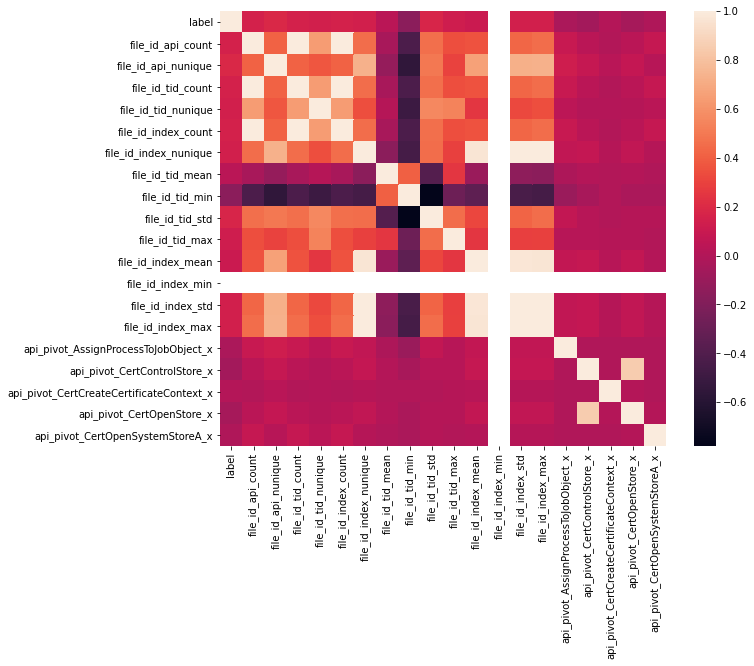

In [18]:
# 模型结果分析
# 采样10000个样本，观察其中20个特征的线性相关性
plt.figure(figsize=[10,8])
sns.heatmap(train_data.iloc[:10000, 1:21].corr())

In [19]:
# 特种重要性分析
feature_importance = pd.DataFrame()
feature_importance['fea_name'] = train_features
feature_importance['fea_imp'] = clf.feature_importance()
feature_importance = feature_importance.sort_values(
    'fea_imp', ascending=False
)
feature_importance.sort_values('fea_imp',  ascending=False)

,fea_name,fea_imp
6,file_id_tid_mean,3343
146,api_pivot_LdrGetProcedureAddress_x,3316
9,file_id_tid_max,2984
7,file_id_tid_min,2855
8,file_id_tid_std,2490
...,...,...
593,api_pivot_listen_y,0
44,api_pivot_CryptDecrypt_x,0
35,api_pivot_CreateRemoteThreadEx_x,0
283,api_pivot_WSASocketA_x,0


<AxesSubplot:xlabel='fea_name', ylabel='fea_imp'>

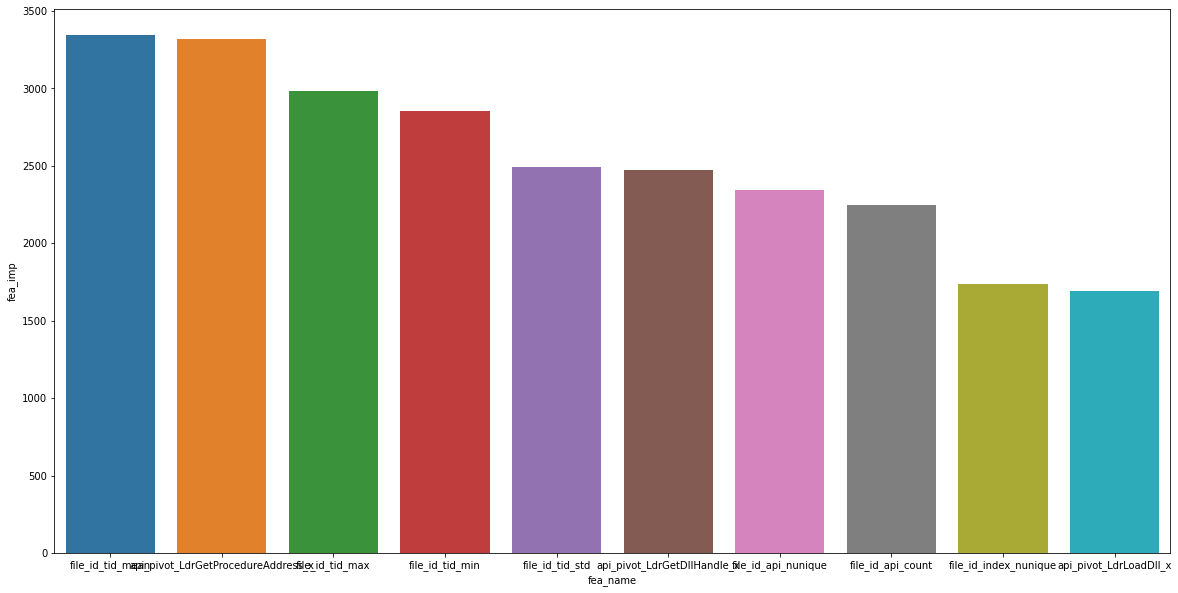

In [20]:
# 把LightGBM的特征重要性进行排序并输出
plt.figure(figsize=[20,10])
sns.barplot(x=feature_importance.iloc[:10]['fea_name'], y=feature_importance.iloc[:10]['fea_imp'])

<AxesSubplot:xlabel='fea_name', ylabel='fea_imp'>

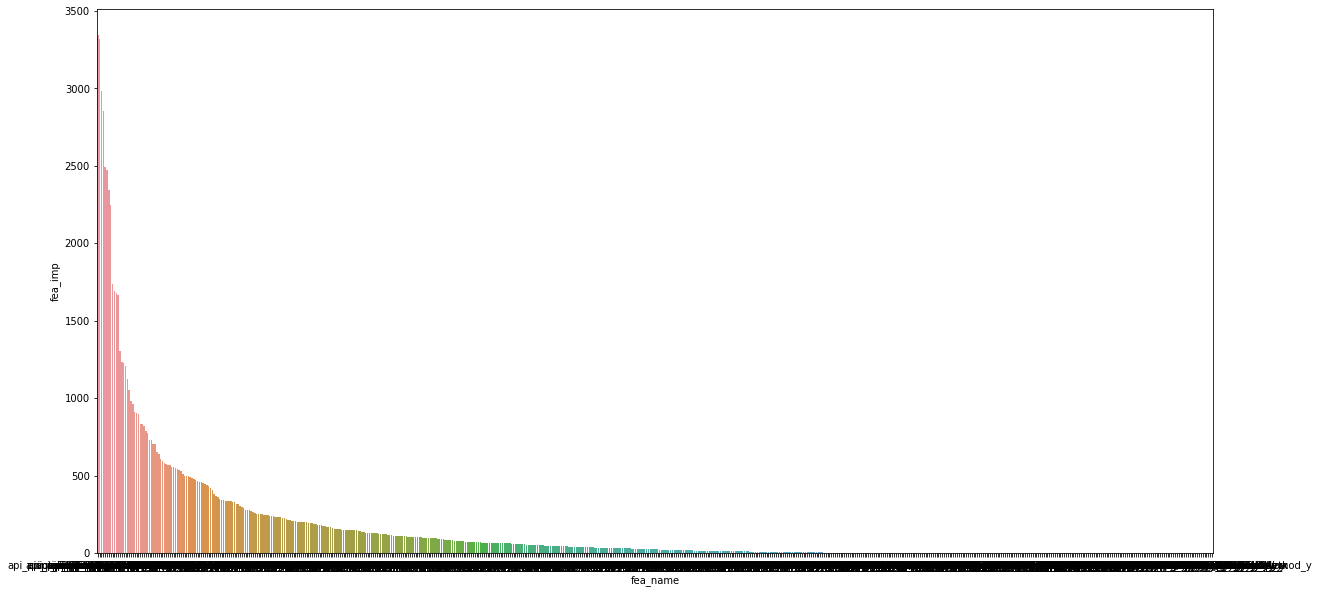

In [21]:
plt.figure(figsize=[20,10])
sns.barplot(x=feature_importance['fea_name'],
            y=feature_importance['fea_imp'])

ImportError: You must install graphviz to plot tree.

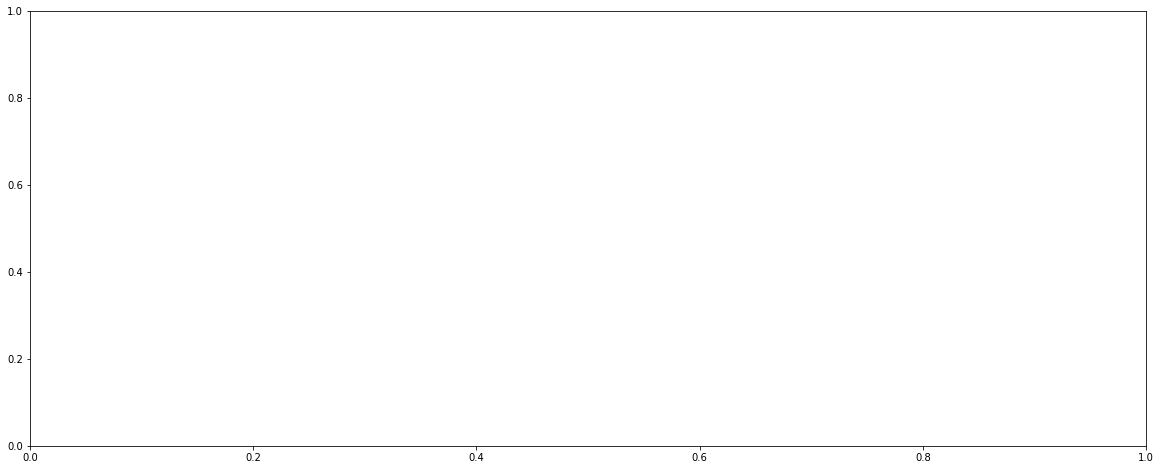

In [28]:
# 树模型绘制。把LightGBM的树模型依次输出，并结合绘制的树模型进行业务的理解。
ax = lgb.plot_tree(clf,
                   tree_index=1,
                   figsize=(20,8),
                   show_info=['split_gain'])
plt.show()

In [27]:
# 5.3.5 模型测试
pred_res = 0
fold = 5
for model in models:
    pred_res += model.predict(test_submit[train_features]) * 1.0 / fold
test_submit['pred0'] = 0
test_submit['pred1'] = 0
test_submit['pred2'] = 0
test_submit['pred3'] = 0
test_submit['pred4'] = 0
test_submit['pred5'] = 0
test_submit['pred6'] = 0
test_submit['pred7'] = 0

test_submit[['prob0', 'prob1', 'prob2', 'prob3', 'prob4', 'prob5', 'prob6', 'prob7']] = pred_res
test_submit[['file_id', 'prob0', 'prob1', 'prob2', 'prob3', 'prob4', 'prob5', 'prob6', 'prob7']].to_csv('baseline2.csv', index=None)

KeyError: "['api_pivot_RtlCompressBuffer_y', 'api_pivot_WSASendTo_y', 'api_pivot_EncryptMessage_y', 'api_pivot_EncryptMessage_x', 'api_pivot_RtlCompressBuffer_x', 'api_pivot_WSASendTo_x'] not in index"